In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [2]:
dta = np.loadtxt('data/incomes.txt')

### a)
Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the density=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

(0, 150000)

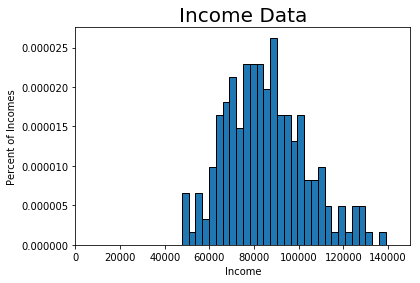

In [3]:
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

### b)
Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix $\hat{W}$ . Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.


In [4]:
mu_init = 11
sig_init = .5
cut_lb = 0
cut_ub = 150000

In [5]:
def log_norm(x,mu,sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
    pdf_vals = ((1/(x*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(x) - mu)**2 / (2 * sigma**2))))/(prob_notcut)
    return pdf_vals

In [6]:
def data_moments(xvals):

    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma,cut_lb, cut_ub):
    xfx = lambda x: x * log_norm(x, mu, sigma,cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * log_norm(x, mu, sigma,cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model #mean and variance of model distributions


def err_vec(xvals, mu, sigma,cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma,cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals,cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma,cut_lb, cut_ub,simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (dta,cut_lb, cut_ub, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-7, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 11.336909418504783  sig_GMM1= 0.21302747638067634


      fun: array([[4.73980413e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.14893283e-06, 3.39760877e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([11.33690942,  0.21302748])

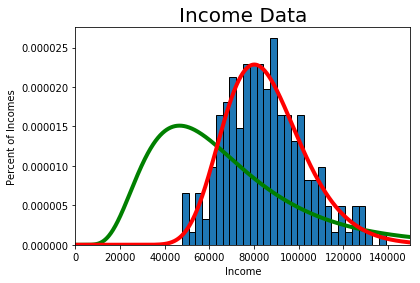

In [8]:
#Graph
x_pts = np.linspace(.01,150000,1000)
#Histogram
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

#Original Estimates
plt.plot(x_pts,log_norm(x_pts,mu_init,sig_init,cut_lb, cut_ub),linewidth=4, color='g')

#GMM Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM1,sig_GMM1,cut_lb, cut_ub),linewidth=4, color='r')

In [9]:
mean_data, var_data = data_moments(dta)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1,cut_lb, cut_ub)
err1 = err_vec(dta, mu_GMM1, sig_GMM1,cut_lb, cut_ub,False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
results

Mean of points = 85276.82360625811 , Variance of points = 323731572.2295289
Mean of model = 85276.75011779145 , Variance of model = 323732219.4633936
Error vector= [-8.61763649e-07  1.99929176e-06]


      fun: array([[4.73980413e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.14893283e-06, 3.39760877e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([11.33690942,  0.21302748])

In [10]:
def Jac_err2(xvals, mu, sigma,cut_lb, cut_ub,simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec(xvals, mu + h_mu, sigma,cut_lb, cut_ub,simple) -
          err_vec(xvals, mu - h_mu, sigma,cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec(xvals, mu, sigma + h_sig,cut_lb, cut_ub, simple) -
          err_vec(xvals, mu, sigma - h_sig,cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [11]:
N = dta.shape[0]
d_err2 = Jac_err2(dta, mu_GMM1, sig_GMM1,cut_lb, cut_ub,False)
print(d_err2)
print(W_hat)
SigHat2 = (1 / N) * lin.inv(d_err2.T @ W_hat @ d_err2)
print(SigHat2)
print('Std. err. mu_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2[1, 1]))

[[ 0.92059837 -0.02062006]
 [ 1.42719666  8.31522325]]
[[1. 0.]
 [0. 1.]]
[[ 0.00585463 -0.00100326]
 [-0.00100326  0.00024423]]
Std. err. mu_hat= 0.07651555493357863
Std. err. sig_hat= 0.01562793512204918


### c) 
Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix $\hat{\Omega}_{2 step}$, which you then use to get the two-step estimator for the optimal weighting matrix $\hat{W}_{2 step}$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.

In [12]:
def weight_2(xvals, mu, sigma,cut_lb, cut_ub,simple=False):
    R = 2
    N = len(dta)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma,cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = xvals - mean_model
        Err_mat[1, :] = ((mean_data - xvals) ** 2) - var_model
    else:
        Err_mat[0, :] = (xvals - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - xvals) ** 2) - var_model) / var_model
    
    return Err_mat

In [13]:
Err_mat = weight_2(dta, mu_GMM1, sig_GMM1, cut_lb, cut_ub,False)
VCV2 = (1 / dta.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.04451678 0.09358605]
 [0.09358605 1.94755883]]
[[24.98769853 -1.200734  ]
 [-1.200734    0.57116219]]


In [14]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (dta, cut_lb, cut_ub,W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.336909999915031  sig_GMM2= 0.21302689616404144


In [16]:
mean_data, var_data = data_moments(dta)
mean_model, var_model = model_moments(mu_GMM2, sig_GMM2,cut_lb, cut_ub)
err1 = err_vec(dta, mu_GMM1, sig_GMM1,cut_lb, cut_ub,False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
results

Mean of points = 85276.82360625811 , Variance of points = 323731572.2295289
Mean of model = 85276.79678206936 , Variance of model = 323730926.20600134
Error vector= [-8.61763649e-07  1.99929176e-06]


      fun: array([[3.23946801e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.20434990e-05, -1.20494171e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.33691  ,  0.2130269])

In [17]:
#Standard Errors

d_err2_2 = Jac_err2(dta, mu_GMM2, sig_GMM2, cut_lb, cut_ub,False)
print(d_err2_2)
print(W_hat2)
SigHat2_2 = (1 / N) * lin.inv(d_err2.T @ W_hat2 @ d_err2)
print(SigHat2_2)
print('Std. err. mu_hat=', np.sqrt(SigHat2_2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2_2[1, 1]))

[[ 0.92059973 -0.02061855]
 [ 1.42719517  8.31522424]]
[[24.98769853 -1.200734  ]
 [-1.200734    0.57116219]]
[[2.63415217e-04 1.88241964e-05]
 [1.88241964e-05 1.26613878e-04]]
Std. err. mu_hat= 0.016230071367320926
Std. err. sig_hat= 0.011252283236312397


In [19]:
#Critical Value
err = err_vec(dta, mu_GMM2, sig_GMM2,cut_lb, cut_ub,simple=False)
crit_val = err.T @ W_hat2 @ err
crit_val

array([[3.23946801e-12]])

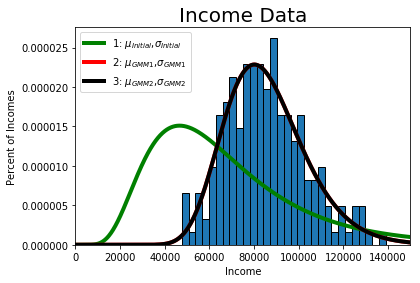

In [20]:
#Graph
x_pts = np.linspace(.01,150000,1000)
#Histogram
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

#Original Estimates
plt.plot(x_pts,log_norm(x_pts,mu_init,sig_init,cut_lb, cut_ub),linewidth=4, color='g',
         label='1: $\mu_{Initial}$,$\sigma_{Initial}$')

#GMM Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM1,sig_GMM1,cut_lb, cut_ub),linewidth=4, color='r',
         label='2: $\mu_{GMM1}$,$\sigma_{GMM1}$')

#GMM_2 Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM2,sig_GMM2,cut_lb, cut_ub),linewidth=4, color='k',
         label='3: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

### d) 
Now estimate the lognormal PDF to fit the data by GMM using different moments. Use percent of individuals who earn less than $75,000$, percent of individuals who earn between $75,000$ and $100,000$, and percent of individuals who earn more than $100,000$ as your three moments. Use the identity matrix as your estimator for the optimal weighting matrix. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [21]:
def data_moments2(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 220
    bpct_2_dat = scalar in [0, 1], percent of observations
                 220 <= x < 320
    bpct_3_dat = scalar in [0, 1], percent of observations
                 320 <= x < 430
    bpct_4_dat = scalar in [0, 1], percent of observations
                 430 <= x <= 450

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments2(mu, sigma,cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    bpct_4_mod = scalar in [0, 1], percent of model observations in
                 bin 4
    bp_4_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_4_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: log_norm(x, mu, sigma,cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec2(xvals, mu, sigma,cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments2(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments2(mu, sigma,cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion2(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals,cut_lb, cut_ub, W = args
    err = err_vec2(xvals, mu, sigma,cut_lb, cut_ub,simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [22]:
params = np.array([mu_GMM1, sig_GMM1])
print('params=', params)
print(data_moments2(dta))
print(model_moments2(mu_GMM1, sig_GMM1,cut_lb, cut_ub))
print(criterion2(params,dta,cut_lb, cut_ub,np.eye(3)))

params= [11.33690942  0.21302748]
(0.3, 0.5, 0.2)
(0.30007458010542226, 0.49559706232849987, 0.20115785803911337)
[[0.00011112]]


In [28]:
params_init = np.array([mu_GMM2, sig_GMM2])
W_hat1_3 = np.eye(3) 
gmm_args = (dta,cut_lb, cut_ub, W_hat1_3)
results_3 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', tol= 1e-14,bounds=((1e-10, None), (1e-10, None)))
#tol = keep looking until next answer changes less than input number
mu_GMM3, sig_GMM3 = results_3.x
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)

mu_GMM3= 11.33672664926126  sig_GMM3= 0.21174642493904886


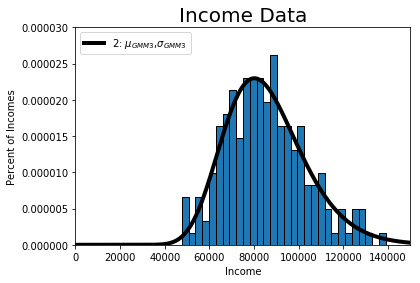

In [29]:
#Graph
x_pts = np.linspace(.00000001,150000,1000)
#Histogram
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])
plt.ylim([0,.000030])

#GMM_3 Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM3,sig_GMM3,cut_lb, cut_ub),linewidth=4, color='k',
         label='2: $\mu_{GMM3}$,$\sigma_{GMM3}$')

plt.legend(loc='upper left')

In [30]:
params = np.array([mu_GMM3, sig_GMM3])
print('params=', params)
print(data_moments2(dta))
print(model_moments2(mu_GMM3, sig_GMM3,cut_lb, cut_ub))
print(criterion2(params, dta,cut_lb, cut_ub,W_hat1_3))

params= [11.33672665  0.21174642]
(0.3, 0.5, 0.2)
(0.29927245329130364, 0.4980574469828858, 0.1996627912064373)
[[2.38181733e-05]]


### e) 

Perform the two-step GMM estimator by using your estimates from part (d) with three moments to generate an estimator for the variance covariance matrix $\hat{\Omega}_{2step}$, which you then use to get the two-step estimator for the optimal weighting matrix $\hat{W}_{2step}$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated log- normal PDF against the histogram from part (a) and the estimated PDF from part (d). Report and compare your three data moments against your three model moments at the estimated parameter values.

In [31]:
def weight_3(dta, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded
    R = 4.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    R          = 2, hard coded number of moments
    N          = integer >= R, number of data observations
    Err_mat    = (R, N) matrix, error by moment and observation data
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: Err_mat
    --------------------------------------------------------------------
    '''
    R = 4
    N = len(dta)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments2(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = dta < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (dta >= 75000) & (dta < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = dta >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = dta < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (dta >= 75000) & (dta < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = dta >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [32]:
Err_mat2 = weight_3(dta, mu_GMM3, sig_GMM3, cut_lb, cut_ub,False)
VCV2 = (1 / dta.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat3 = lin.inv(VCV2)
print(W_hat3)

[[0.04451678 0.09358605]
 [0.09358605 1.94755883]]
[[24.98769853 -1.200734  ]
 [-1.200734    0.57116219]]


In [33]:
params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (dta, cut_lb, cut_ub,W_hat3)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)

mu_GMM4= 11.336910340104296  sig_GMM4= 0.21302706908326272


In [34]:
#Critical Value
err = err_vec(dta, mu_GMM4, sig_GMM4,cut_lb, cut_ub,simple=False)
crit_val = err.T @ W_hat3 @ err
crit_val

array([[2.72897776e-15]])

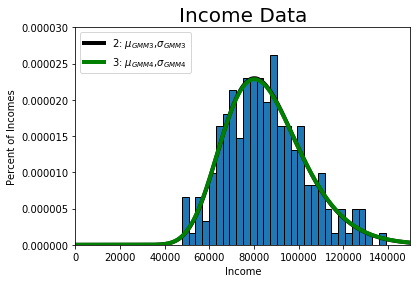

In [35]:
#Graph

#Histogram
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])
plt.ylim([0,.000030])

#GMM_3 Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM3,sig_GMM3,cut_lb, cut_ub),linewidth=4, color='k',
         label='2: $\mu_{GMM3}$,$\sigma_{GMM3}$')

#GMM_4 Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM4,sig_GMM4,cut_lb, cut_ub),linewidth=4, color='g',
         label='3: $\mu_{GMM4}$,$\sigma_{GMM4}$')

plt.legend(loc='upper left')


In [36]:
#Model Moments
print(model_moments2(mu_GMM4, sig_GMM4,cut_lb, cut_ub))

(0.30007272724504547, 0.49559813637609734, 0.20115864543587275)
